In [1]:
import os
os.environ["KMP_WARNINGS"] = "off"
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [3]:
common_config.figure_journal_basic()

In [4]:
import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib
import seaborn as sns

In [5]:
adata = sc.read_h5ad("data/norman_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 111255 × 4000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [6]:
adata.obs["gemgroup"] = adata.obs["gemgroup"].astype("category")

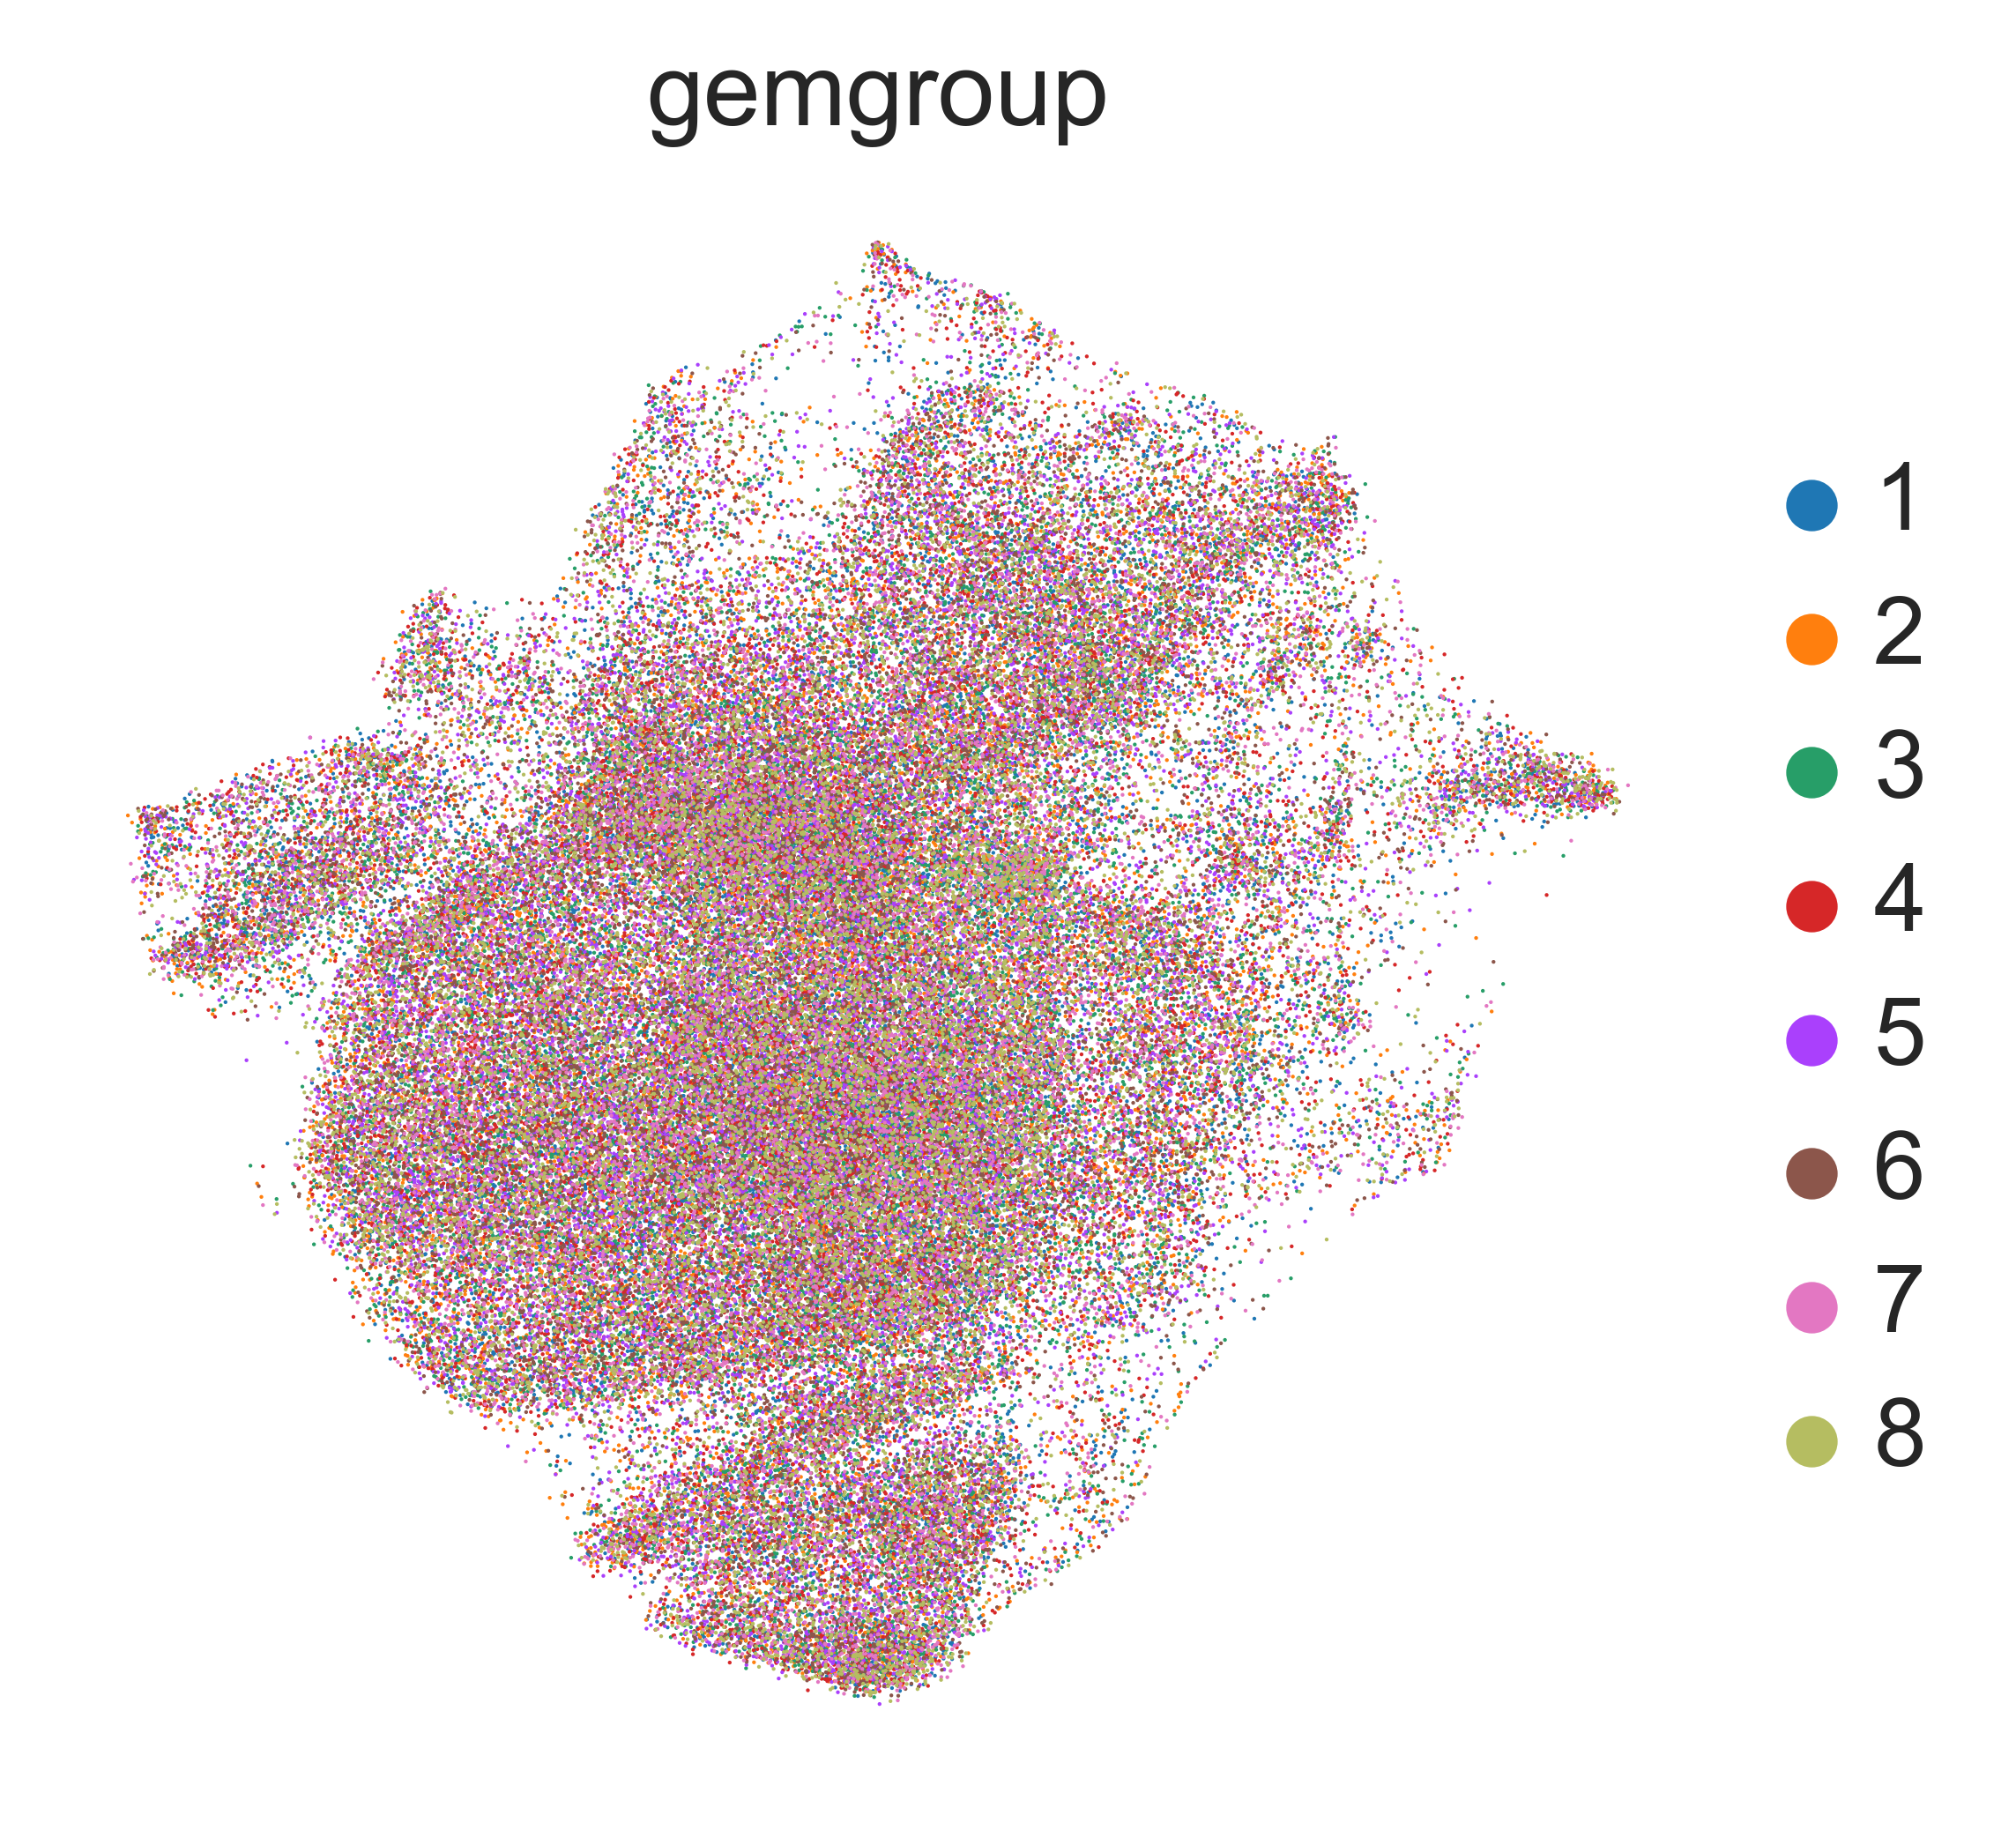

In [7]:
sc.pl.umap(adata, color="gemgroup")

In [8]:
G1_CYCLE = [
    "CDKN1A",
    {"CDKN1B", "CDKN1A"},
    "CDKN1B",
    {"CDKN1C", "CDKN1A"},
    {"CDKN1C", "CDKN1B"},
    "CDKN1C",
]

ERYTHROID = [
    {"CBL", "CNN1"},
    {"CBL", "PTPN12"},
    {"CBL", "PTPN9"},
    {"CBL", "UBASH3B"},
    {"SAMD1", "PTPN12"},
    {"SAMD1", "UBASH3B"},
    {"UBASH3B", "CNN1"},
    {"UBASH3B", "PTPN12"},
    {"UBASH3B", "PTPN9"},
    {"UBASH3B", "UBASH3A"},
    {"UBASH3B", "ZBTB25"},
    {"BPGM", "SAMD1"},
    "PTPN1",
    {"PTPN12", "PTPN9"},
    {"PTPN12", "UBASH3A"},
    {"PTPN12", "ZBTB25"},
    {"UBASH3A", "CNN1"},
]

PIONEER_FACTORS = [
    {"FOXA1", "FOXF1"},
    {"FOXA1", "FOXL2"},
    {"FOXA1", "HOXB9"},
    {"FOXA3", "FOXA1"},
    {"FOXA3", "FOXF1"},
    {"FOXA3", "FOXL2"},
    {"FOXA3", "HOXB9"},
    "FOXA3",
    {"FOXF1", "FOXL2"},
    {"FOXF1", "HOXB9"},
    {"FOXL2", "MEIS1"},
    "HOXA13",
    "HOXC13",
    {"POU3F2", "FOXL2"},
    "TP73",
    "MIDN",
    {"LYL1", "IER5L"},
    "HOXC13",
    {"DUSP9", "SNAI1"},
    {"ZBTB10", "SNAI1"},
]

GRANULOCYTE_APOPTOSIS = [
    "SPI1",
    "CEBPA",
    {"CEBPB", "CEBPA"},
    "CEBPB",
    {"CEBPE", "CEBPA"},
    {"CEBPE", "CEBPB"},
    {"CEBPE", "RUNX1T1"},
    {"CEBPE", "SPI1"},
    "CEBPE",
    {"ETS2", "CEBPE"},
    {"KLF1", "CEBPA"},
    {"FOSB", "CEBPB"},
    {"FOSB", "CEBPE"},
    {"ZC3HAV1", "CEBPA"},
    {"JUN", "CEBPA"},
]

PRO_GROWTH = [
    {"CEBPE", "KLF1"},
    "KLF1",
    {"KLF1", "BAK1"},
    {"KLF1", "MAP2K6"},
    {"KLF1", "TGFBR2"},
    "ELMSAN1",
    {"MAP2K3", "SLC38A2"},
    {"MAP2K3", "ELMSAN1"},
    "MAP2K3",
    {"MAP2K3", "MAP2K6"},
    {"MAP2K6", "ELMSAN1"},
    "MAP2K6",
    {"MAP2K6", "KLF1"},
]

MEGAKARYOCYTE = [
    {"MAPK1", "TGFBR2"},
    "MAPK1",
    {"ETS2", "MAPK1"},
    "ETS2",
    {"CEBPB", "MAPK1"},
]

programmes = {
    "G1 cell cycle": G1_CYCLE,
    "Erythroid": ERYTHROID,
    "Pioneer factors": PIONEER_FACTORS,
    "Granulocyte apoptosis": GRANULOCYTE_APOPTOSIS,
    "Pro-growth": PRO_GROWTH,
    "Megakaryocyte": MEGAKARYOCYTE,
}

In [9]:
gene_programme = []

for target_pert in adata.obs["perturbation_name"]:
    if target_pert == "control":
        gene_programme.append("Control")
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (type(pert) == set and pert == set(target_pert.split("+"))) or (
                target_pert == pert
            ):
                gene_programme.append(programme)
                found_programme = True
                break

    if not found_programme:
        gene_programme.append("Unknown")

adata.obs["gene_programme"] = gene_programme
adata.obs["gene_programme"] = adata.obs["gene_programme"].astype("category")

In [10]:
ps = pt.tl.MLPClassifierSpace()

In [11]:
pert_embeddings = ps.compute(
    adata,
    target_col="perturbation_name",
    hidden_dim=[512, 256],
    dropout=0.05,
    batch_size=128, #64,
    batch_norm=True,
    max_epochs=5,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | net  | MLP  | 2.2 M 
------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.969     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.114367485046387     │
└───────────────────────────┴───────────────────────────┘

In [12]:
ps = pt.tl.PseudobulkSpace()
psadata_classifier = ps.compute(
    pert_embeddings,
    target_col="perturbations",
    groups_col="perturbations",
    mode="mean",
    min_cells=0,
    min_counts=0,
)

In [13]:
sc.pp.neighbors(psadata_classifier, use_rep="X")
sc.tl.umap(psadata_classifier)
sc.pl.umap(psadata_classifier, color="perturbations", show=False)

<Axes: title={'center': 'perturbations'}, xlabel='UMAP1', ylabel='UMAP2'>

In [17]:
# convert all obs to str
for obs in psadata_classifier.obs.columns:
    psadata_classifier.obs[obs] = psadata_classifier.obs[obs].astype(str)

In [19]:
# save the classifier space
psadata_classifier.write("data/norman_classifier_no_preprocessing.h5ad")

In [18]:
psadata_classifier.obs

perturbations guide_AHR guide_ARID1A guide_ARRDC3 guide_ATL1  \
AHR                AHR         1            0            0          0   
AHR+FEV        AHR+FEV         1            0            0          0   
AHR+KLF1      AHR+KLF1         1            0            0          0   
ARID1A          ARID1A         0            1            0          0   
ARRDC3          ARRDC3         0            0            1          0   
...                ...       ...          ...          ...        ...   
ZBTB10          ZBTB10         0            0            0          0   
ZBTB25          ZBTB25         0            0            0          0   
ZC3HAV1        ZC3HAV1         0            0            0          0   
ZNF318          ZNF318         0            0            0          0   
control        control         0            0            0          0   

         guide_BAK1 guide_BCL2L11 guide_BCORL1 guide_BPGM guide_C19orf26  ...  \
AHR               0             0            0          0              0  ...   
AHR+FEV           0             0            0          0              0  ...   
AHR+KLF1          0             0            0          0              0  ...   
ARID1A            0             0            0          0              0  ...   
ARRDC3            0             0            0          0              0  ...   
...             ...           ...          ...        ...            ...  ...   
ZBTB10            0             0            0          0              0  ...   
ZBTB25            0             0            0          0              0  ...   
ZC3HAV1           0             0            0          0              0  ...   
ZNF318            0             0            0          0              0  ...   
control           0             0            0          0              0  ...   

         guide_ZNF318 guide_ids perturbation_name perturbation_type  \
AHR                 0       AHR               AHR           genetic   
AHR+FEV             0   AHR,FEV           AHR+FEV           genetic   
AHR+KLF1            0  AHR,KLF1          AHR+KLF1           genetic   
ARID1A              0    ARID1A            ARID1A           genetic   
ARRDC3              0    ARRDC3            ARRDC3           genetic   
...               ...       ...               ...               ...   
ZBTB10              0    ZBTB10            ZBTB10           genetic   
ZBTB25              0    ZBTB25            ZBTB25           genetic   
ZC3HAV1             0   ZC3HAV1           ZC3HAV1           genetic   
ZNF318              1    ZNF318            ZNF318           genetic   
control             0                     control           genetic   

         perturbation_value perturbation_unit  perturbed gene_programme  \
AHR                     nan               nan  perturbed        Unknown   
AHR+FEV                 nan               nan  perturbed        Unknown   
AHR+KLF1                nan               nan  perturbed        Unknown   
ARID1A                  nan               nan  perturbed        Unknown   
ARRDC3                  nan               nan  perturbed        Unknown   
...                     ...               ...        ...            ...   
ZBTB10                  nan               nan  perturbed        Unknown   
ZBTB25                  nan               nan  perturbed        Unknown   
ZC3HAV1                 nan               nan  perturbed        Unknown   
ZNF318                  nan               nan  perturbed        Unknown   
control                 nan               nan    control        Control   

         psbulk_n_cells    psbulk_counts  
AHR               558.0    34140.2109375  
AHR+FEV           276.0   24217.26171875  
AHR+KLF1          481.0   47940.08984375  
ARID1A            231.0  11188.376953125  
ARRDC3            494.0   31889.87890625  
...                 ...              ...  
ZBTB10            160.0    7239.50390625  
ZBTB25            739.0   43077.11328125  
ZC3HAV1           

In [20]:
sc.pl.umap(psadata_classifier, color="gene_programme")